# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-01 17:30:52.860651: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 17:30:52.889258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 17:30:54.124530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 17:30:54.128723: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-06-01 17:30:54.866778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


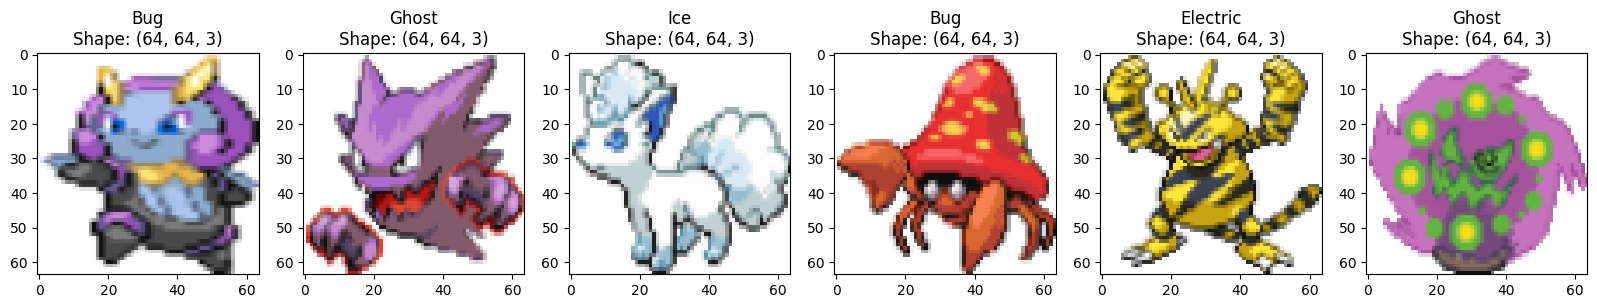

2024-06-01 17:30:56.277936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Training

Epoch 1/500


I0000 00:00:1717263072.240383  113417 service.cc:145] XLA service 0x701510002a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717263072.240416  113417 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-01 17:31:12.622800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1717263073.100545  113417 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-06-01 17:31:14.156462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717263077.336516  113887 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes 

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:14:10 35s/step - mae: 1.0661 - loss: 1.8036

I0000 00:00:1717263096.189821  113417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - mae: 0.7704 - loss: 0.9735
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.4113 - loss: 0.3087
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.3314 - loss: 0.2139
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.2977 - loss: 0.1789
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - mae: 0.2741 - loss: 0.1564
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.2566 - loss: 0.1399
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.2508 - loss: 0.1381
Epoch 8/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - mae: 0.2371 - loss: 0.1235
Epoch 9/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.2315 - loss: 0.1205
Epoch 10/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.2230 - loss: 0.1136
Epoch 11/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.2205 - loss: 0.1123
Epoch 12/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.2235 - lo

Sampling sprite...: 100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


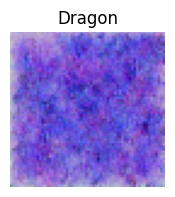

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 879ms/step - mae: 0.1938 - loss: 0.0951
Epoch 21/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1956 - loss: 0.0978
Epoch 22/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1898 - loss: 0.0921
Epoch 23/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1919 - loss: 0.0961
Epoch 24/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1897 - loss: 0.0933
Epoch 25/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1855 - loss: 0.0904
Epoch 26/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1838 - loss: 0.0890
Epoch 27/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1836 - loss: 0.0898
Epoch 28/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1807 - loss: 0.0872
Epoch 29/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1873 - loss: 0.0940
Epoch 30/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1797 - loss: 0.0870
Epoch 31/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.34it/s]


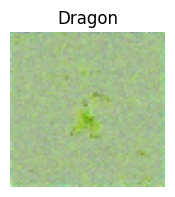

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 859ms/step - mae: 0.1701 - loss: 0.0814
Epoch 41/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1697 - loss: 0.0806
Epoch 42/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1685 - loss: 0.0798
Epoch 43/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1726 - loss: 0.0834
Epoch 44/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1648 - loss: 0.0753
Epoch 45/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1682 - loss: 0.0800
Epoch 46/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1670 - loss: 0.0783
Epoch 47/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1655 - loss: 0.0780
Epoch 48/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1650 - loss: 0.0773
Epoch 49/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1662 - loss: 0.0781
Epoch 50/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1654 - loss: 0.0782
Epoch 51/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


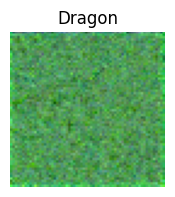

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 856ms/step - mae: 0.1592 - loss: 0.0733
Epoch 61/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1606 - loss: 0.0749
Epoch 62/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1618 - loss: 0.0755
Epoch 63/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1626 - loss: 0.0763
Epoch 64/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1574 - loss: 0.0723
Epoch 65/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1593 - loss: 0.0744
Epoch 66/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1579 - loss: 0.0730
Epoch 67/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1616 - loss: 0.0764
Epoch 68/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1609 - loss: 0.0754
Epoch 69/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1563 - loss: 0.0713
Epoch 70/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1621 - loss: 0.0759
Epoch 71/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]


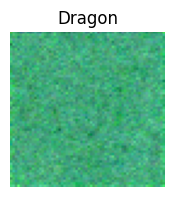

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 855ms/step - mae: 0.1564 - loss: 0.0711
Epoch 81/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1532 - loss: 0.0696
Epoch 82/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1546 - loss: 0.0699
Epoch 83/500
 80/127 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - mae: 0.1542 - loss: 0.0725

In [6]:
diff_callback = DiffusionCallback(model, 20, "Dragon")
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[diff_callback])

In [ ]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)

In [ ]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

## 2.2. Results and save model

In [ ]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")
model.plot_samples(6, "Dragon")

In [ ]:
# Save the model
# =====================================================================
# model.save(f"{MODELS_PATH}/diffusion_model") TODO: TBC

[BACK TO TOP](#top)